In [1]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/sample.csv.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,2.5,7.165589,0.0,1.0,20.64,2.5,0.0
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,3.5,6.067401,0.0,1.0,25.55,2.5,0.0
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,0.0,4.111547,0.0,1.0,17.64,2.5,0.0
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,2.5,6.411079,0.0,1.0,12.80,2.5,0.0
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,1.0,4.769377,0.0,1.0,18.00,2.5,0.0


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from scipy import stats
import xgboost as xgb

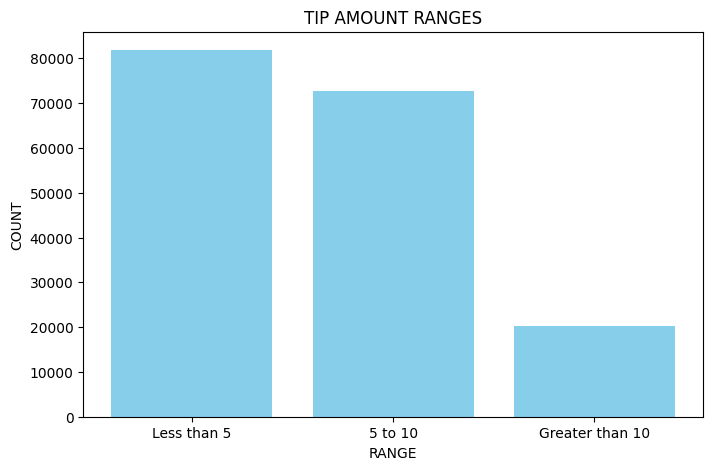

In [4]:
tip_less_than_5 = df[df['tip_amount'] < 5]
tip_between_5_and_10 = df[(df['tip_amount'] >= 5) & (df['tip_amount'] <= 10)]
tip_greater_than_10 = df[df['tip_amount'] > 10]

# Count the tip amount
count_less_than_5 = len(tip_less_than_5)
count_between_5_and_10 = len(tip_between_5_and_10)
count_greater_than_10 = len(tip_greater_than_10)

plt.figure(figsize=(8,5))
plt.bar(['Less than 5', '5 to 10', 'Greater than 10'], [count_less_than_5, count_between_5_and_10, count_greater_than_10], color="skyblue")
plt.title("TIP AMOUNT RANGES")
plt.xlabel("RANGE")
plt.ylabel("COUNT")
plt.show()

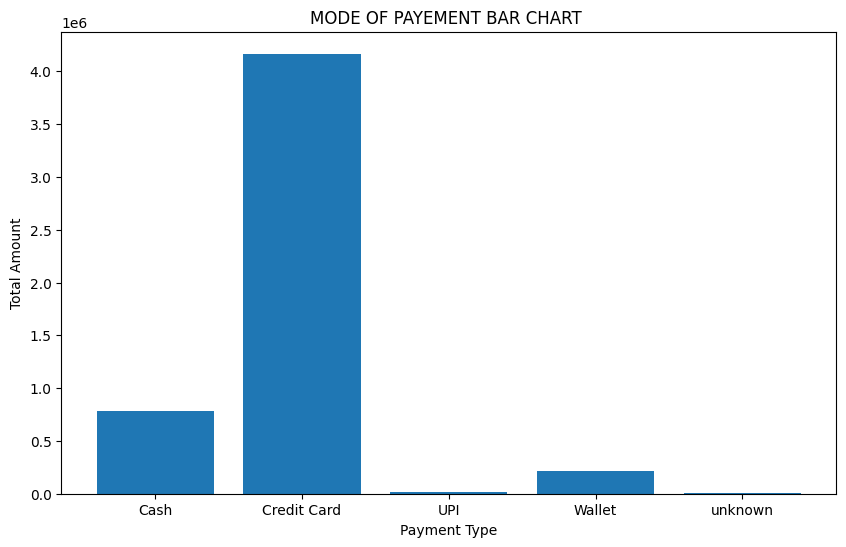

In [5]:
pay_totals = df.groupby("payment_type")["total_amount"].sum().reset_index()
plt.figure(figsize=(10,6))
plt.bar(pay_totals["payment_type"],pay_totals["total_amount"])
plt.xlabel("Payment Type")
plt.ylabel("Total Amount")
plt.title("MODE OF PAYEMENT BAR CHART ")
plt.show()

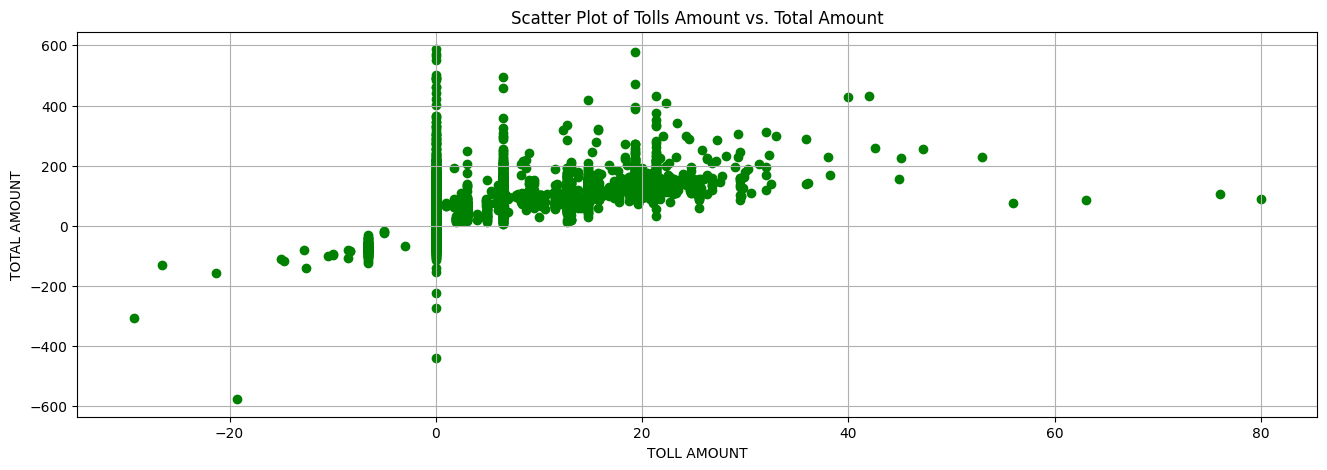

In [6]:
plt.figure(figsize=(16,5))
plt.scatter(df['tolls_amount'], df['total_amount'], c='GREEN', marker='o')
plt.title('Scatter Plot of Tolls Amount vs. Total Amount')
plt.xlabel('TOLL AMOUNT')
plt.ylabel('TOTAL AMOUNT')
plt.grid(True)
plt.show()

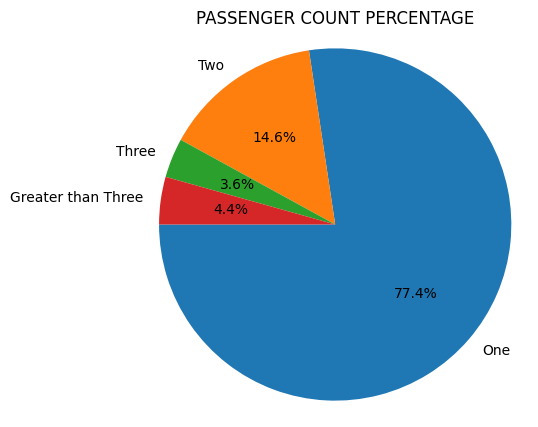

In [7]:
# Count passenger counts in each category
one_count = (df['passenger_count'] == 1).sum()
two_count = (df['passenger_count'] == 2).sum()
three_count = (df['passenger_count'] == 3).sum()
greater_than_three_count = (df['passenger_count'] > 3).sum()

#pie chart
plt.figure(figsize=(5, 5))
categories = ['One', 'Two', 'Three', 'Greater than Three']
counts = [one_count, two_count, three_count, greater_than_three_count]
plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=180)
plt.title("PASSENGER COUNT PERCENTAGE")
plt.axis("equal")
plt.show()


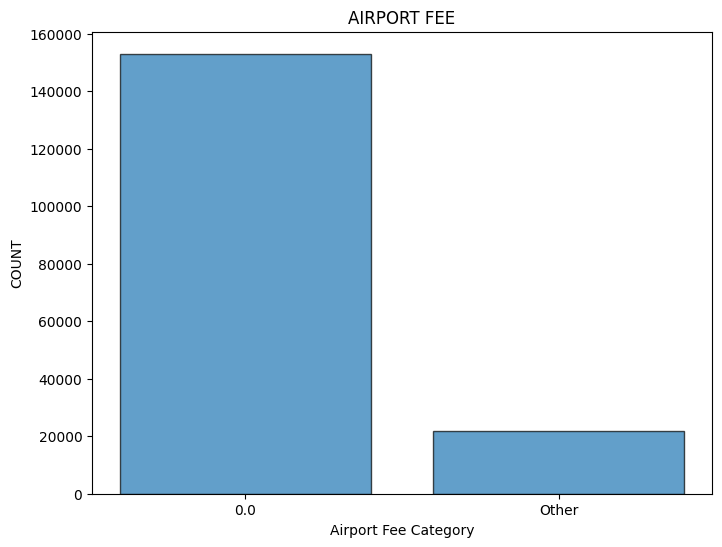

In [8]:
#copy of the DataFrame
df_copy = df.copy()

categorized_fee = np.where((df_copy['Airport_fee'] == 0), df_copy['Airport_fee'].astype(str), 'Other')
df_copy['Airport_fee_category'] = categorized_fee

# Count each category
fee_category_counts = df_copy['Airport_fee_category'].value_counts()

# Bar graph
plt.figure(figsize=(8, 6))
plt.bar(fee_category_counts.index, fee_category_counts.values, edgecolor='black', alpha=0.7)
plt.xlabel('Airport Fee Category')
plt.ylabel('COUNT')
plt.title('AIRPORT FEE')
plt.show()


In [9]:
df.isnull().sum()

VendorID                    0
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count          6077
trip_distance               0
RatecodeID               6077
store_and_fwd_flag       6077
PULocationID                0
DOLocationID                0
payment_type                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge     6077
Airport_fee              6077
dtype: int64

In [10]:
def preprocess_columns(df):
    # 1.check and change datetime columns
    checks= df['tpep_pickup_datetime'] > df['tpep_dropoff_datetime']
    df.loc[checks, ['tpep_pickup_datetime', 'tpep_dropoff_datetime']] = df.loc[checks, ['tpep_dropoff_datetime', 'tpep_pickup_datetime']].values

    # 2.Durations
    df['pickup_time'] = pd.to_datetime(df['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    df['dropoff_time'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

    df['time_difference_hours'] = (df['dropoff_time'] - df['pickup_time']).dt.total_seconds() /3600
    df['time_difference_hours'] = df['time_difference_hours'].round(2)

    # 3.REMOVE Columns
    df = df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_time', 'dropoff_time'], axis=1)
    return df

df=preprocess_columns(df)


In [11]:
df.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,time_difference_hours
0,1,1.0,2.14,1.0,N,120,9,Credit Card,2.5,7.165589,0.0,1.0,20.64,2.5,0.0,0.76
1,0,1.0,2.70,1.0,N,15,215,Credit Card,3.5,6.067401,0.0,1.0,25.55,2.5,0.0,1.06
2,1,1.0,1.15,1.0,N,167,223,Credit Card,0.0,4.111547,0.0,1.0,17.64,2.5,0.0,0.89
3,0,1.0,0.40,1.0,N,128,239,Credit Card,2.5,6.411079,0.0,1.0,12.80,2.5,0.0,0.95
4,1,3.0,1.10,1.0,N,203,52,Credit Card,1.0,4.769377,0.0,1.0,18.00,2.5,0.0,0.31


In [12]:
df.isnull().sum()

VendorID                    0
passenger_count          6077
trip_distance               0
RatecodeID               6077
store_and_fwd_flag       6077
PULocationID                0
DOLocationID                0
payment_type                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge     6077
Airport_fee              6077
time_difference_hours       0
dtype: int64

In [13]:
def filling_null_values(df):
    df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})
    df['store_and_fwd_flag'].fillna(0, inplace=True)
    df['passenger_count'].fillna(1, inplace=True)
    congestion_median = df['congestion_surcharge'].median()
    df['congestion_surcharge'].fillna(congestion_median, inplace=True)
    Air_fee_median = df['Airport_fee'].median()
    df['Airport_fee'].fillna(Air_fee_median, inplace=True)
    print(congestion_median, Air_fee_median)

    return df

df = filling_null_values(df)

2.5 0.0


In [14]:
df.isnull().sum()

VendorID                    0
passenger_count             0
trip_distance               0
RatecodeID               6077
store_and_fwd_flag          0
PULocationID                0
DOLocationID                0
payment_type                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge        0
Airport_fee                 0
time_difference_hours       0
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               175000 non-null  int64  
 1   passenger_count        175000 non-null  float64
 2   trip_distance          175000 non-null  float64
 3   RatecodeID             168923 non-null  float64
 4   store_and_fwd_flag     175000 non-null  float64
 5   PULocationID           175000 non-null  int64  
 6   DOLocationID           175000 non-null  int64  
 7   payment_type           175000 non-null  object 
 8   extra                  175000 non-null  float64
 9   tip_amount             175000 non-null  float64
 10  tolls_amount           175000 non-null  float64
 11  improvement_surcharge  175000 non-null  float64
 12  total_amount           175000 non-null  float64
 13  congestion_surcharge   175000 non-null  float64
 14  Airport_fee            175000 non-nu

In [16]:
def encode_variables(df):
    label = LabelEncoder()
    df['payment_type'] = label.fit_transform(df['payment_type'])

    return df

df = encode_variables(df)

In [17]:
df.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,time_difference_hours
0,1,1.0,2.14,1.0,0.0,120,9,1,2.5,7.165589,0.0,1.0,20.64,2.5,0.0,0.76
1,0,1.0,2.70,1.0,0.0,15,215,1,3.5,6.067401,0.0,1.0,25.55,2.5,0.0,1.06
2,1,1.0,1.15,1.0,0.0,167,223,1,0.0,4.111547,0.0,1.0,17.64,2.5,0.0,0.89
3,0,1.0,0.40,1.0,0.0,128,239,1,2.5,6.411079,0.0,1.0,12.80,2.5,0.0,0.95
4,1,3.0,1.10,1.0,0.0,203,52,1,1.0,4.769377,0.0,1.0,18.00,2.5,0.0,0.31


In [18]:
def manage_negative_values(df):
    negate_columns = []

    for column in df.columns:
        if(df[column]< 0).any():
            negate_columns.append(column)

    for col in negate_columns:
        print(col)

        df.loc[df[col] < 0, col] = 0
    return df

df = manage_negative_values(df)

extra
tolls_amount
improvement_surcharge
total_amount
congestion_surcharge
Airport_fee


In [19]:
df.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,time_difference_hours
0,1,1.0,2.14,1.0,0.0,120,9,1,2.5,7.165589,0.0,1.0,20.64,2.5,0.0,0.76
1,0,1.0,2.70,1.0,0.0,15,215,1,3.5,6.067401,0.0,1.0,25.55,2.5,0.0,1.06
2,1,1.0,1.15,1.0,0.0,167,223,1,0.0,4.111547,0.0,1.0,17.64,2.5,0.0,0.89
3,0,1.0,0.40,1.0,0.0,128,239,1,2.5,6.411079,0.0,1.0,12.80,2.5,0.0,0.95
4,1,3.0,1.10,1.0,0.0,203,52,1,1.0,4.769377,0.0,1.0,18.00,2.5,0.0,0.31


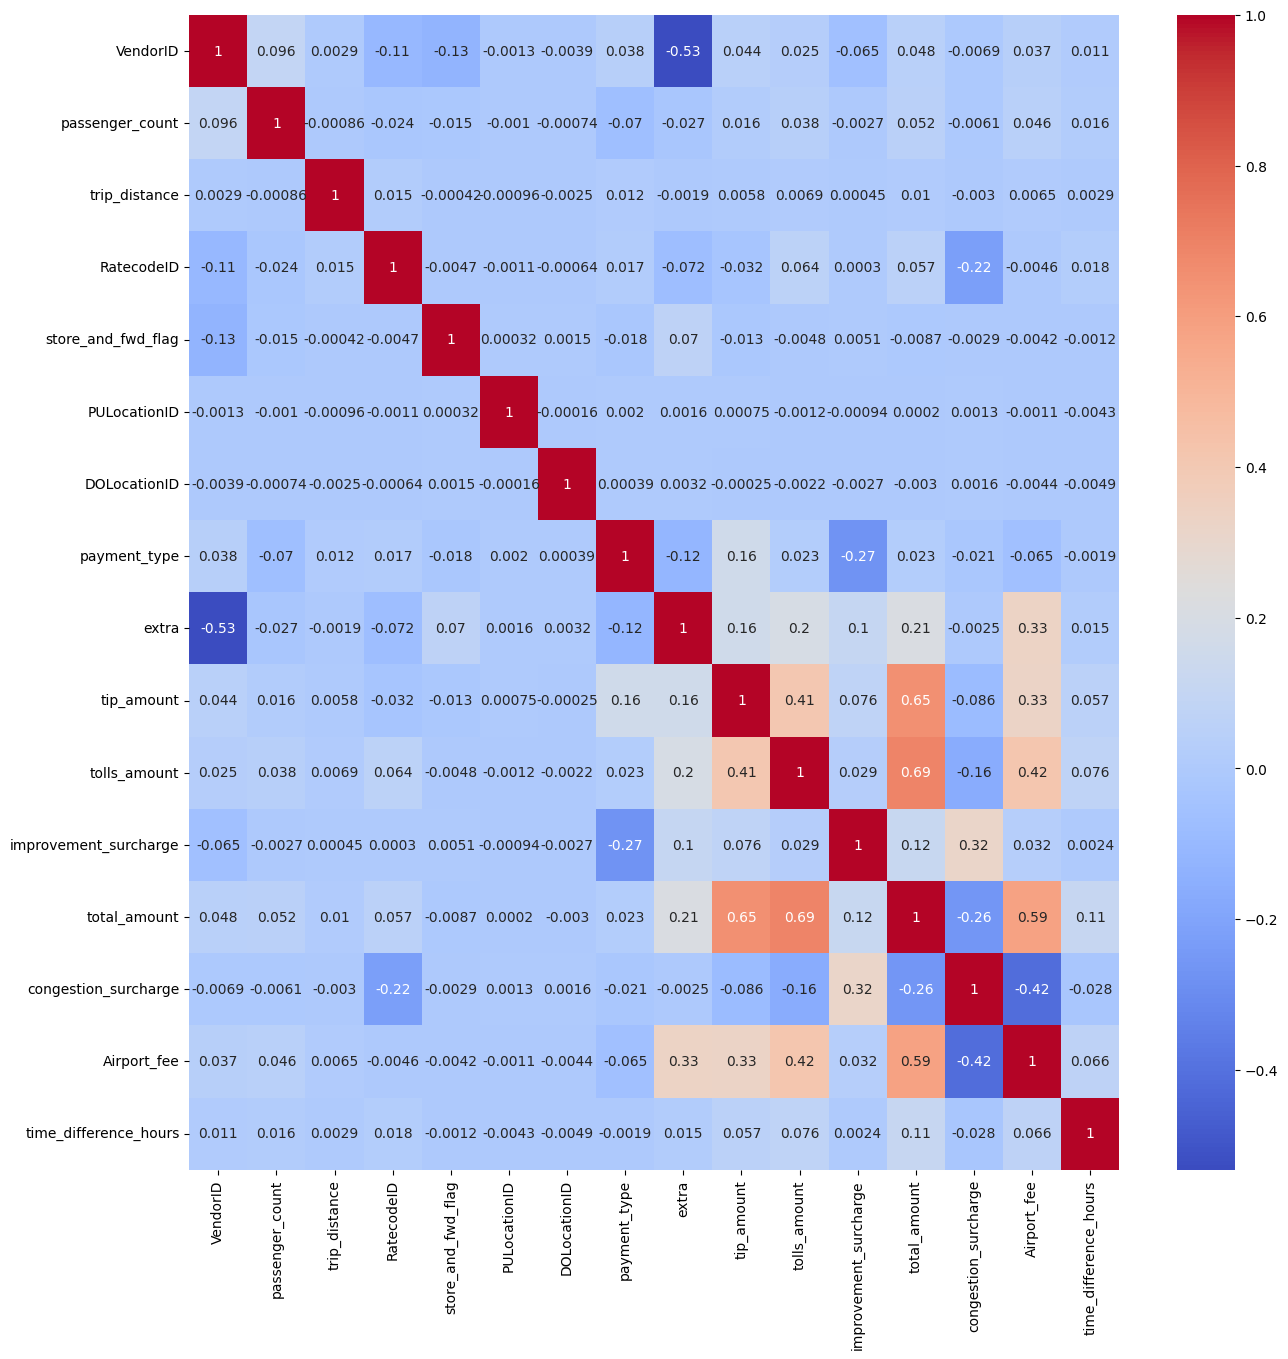

In [20]:
#features for prediction 
cor_mat= df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(cor_mat, annot=True,cmap="coolwarm")
plt.show()

In [21]:
total_cor= cor_mat['total_amount']
print(total_cor)

VendorID                 0.047573
passenger_count          0.051680
trip_distance            0.010270
RatecodeID               0.057211
store_and_fwd_flag      -0.008742
PULocationID             0.000201
DOLocationID            -0.002969
payment_type             0.022813
extra                    0.214260
tip_amount               0.647840
tolls_amount             0.691756
improvement_surcharge    0.116296
total_amount             1.000000
congestion_surcharge    -0.261771
Airport_fee              0.585921
time_difference_hours    0.111539
Name: total_amount, dtype: float64


In [22]:
def drop_columns(df):
    columns_to_drop = ['VendorID', 'passenger_count', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID']
    df = df.drop(columns=columns_to_drop, axis=1)
    return df
df = drop_columns(df)

In [23]:
df.head()
X = df.drop(['total_amount'], axis=1)
Y = df['total_amount']

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [25]:
from xgboost import XGBRegressor

xgb_regressor = XGBRegressor()

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0, 0.01, 0.1, 1],
}

random_search = RandomizedSearchCV(
    xgb_regressor, param_distributions=param_grid,n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42
)

random_search.fit(X_train, Y_train)

print("XGBoost Regressor")
print("Best Hyperparameters:", random_search.best_params_)

best_xgb_regressor = random_search.best_estimator_

Y_pred = best_xgb_regressor.predict(X_test)
print(f"Score: {best_xgb_regressor.score(X_test, Y_test)}")
print(f"r2 score: {r2_score(Y_test, Y_pred)}")
print(f"MAE: {mean_absolute_error(Y_test, Y_pred)}")
print(f"MSE: {mean_squared_error(Y_test, Y_pred)}")

XGBoost Regressor
Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
Score: 0.9412488021230114
r2 score: 0.9412488021230114
MAE: 3.009791058589189
MSE: 35.81278297461325


In [26]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, Y_train)

Y_pre = linear_reg.predict(X_test)
print(f"Score: {linear_reg.score(X_test, Y_test)}")
print(f"r2 score: {r2_score(Y_test, Y_pre)}")
print(f"MAE: {mean_absolute_error(Y_test, Y_pre)}")
print(f"MSE: {mean_squared_error(Y_test, Y_pre)}")


Score: 0.7141788691670239
r2 score: 0.7141788691670239
MAE: 7.9384036090551655
MSE: 174.2270880929412


In [27]:
knn_reg= KNeighborsRegressor()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  
    'weights': ['uniform', 'distance'],
    'p': [1, 2], 
}

grid_sch = GridSearchCV(knn_reg,param_grid, cv=5, scoring='neg_mean_squared_error')
grid_sch.fit(X_train, Y_train)

print("KNN Regressor")
print("Best Hyperparameters:", grid_sch.best_params_)

best_knn_reg = grid_sch.best_estimator_

Y_pred1 = best_knn_reg.predict(X_test)
print(f"Score: {best_knn_reg.score(X_test, Y_test)}")
print(f"r2 score: {r2_score(Y_test, Y_pred1)}")
print(f"MAE: {mean_absolute_error(Y_test, Y_pred1)}")
print(f"MSE: {mean_squared_error(Y_test, Y_pred1)}")

KNN Regressor
Best Hyperparameters: {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Score: 0.9279828303605414
r2 score: 0.9279828303605414
MAE: 3.0382392393387834
MSE: 43.89927967330894


In [28]:
# from sklearn.svm import SVR
# from sklearn.model_selection import RandomizedSearchCV
# svr = SVR()

# param_dist_svr = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'poly', 'rbf'],
#     'gamma': ['scale', 'auto', 0.1, 1],
#     'epsilon': [0.1, 0.2, 0.5]
# }


# rad_sch_svr = RandomizedSearchCV(
#     svr, param_distributions=param_dist_svr, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42
# )

# rad_sch_svr.fit(X_train, Y_train)

# print("Support Vector Regressor - RandomizedSearchCV")
# print("Best Hyperparameters:", rad_sch_svr.best_params_)

# best_svr = rad_sch_svr.best_estimator_

# Y_pred_svr = best_svr.predict(X_test)

# print(f"Score: {best_svr.score(X_test, Y_test)}")
# print(f"r2 score: {r2_score(Y_test, Y_pred_svr)}")
# print(f"MAE: {mean_absolute_error(Y_test, Y_pred_svr)}")
# print(f"MSE: {mean_squared_error(Y_test, Y_pred_svr)}")


In [29]:
df_test = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv')

In [30]:
df_test.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee
0,1,2023-06-29 00:21:20,2023-06-29 00:25:20,1.0,4.95,1.0,N,20,3,Credit Card,1.0,6.067612,0.0,1.0,2.5,0.0
1,1,2023-06-30 17:44:43,2023-06-30 17:53:13,1.0,2.10,1.0,N,9,81,Credit Card,2.5,6.191269,0.0,1.0,2.5,0.0
2,1,2023-06-29 18:17:04,2023-06-29 19:23:48,1.0,0.95,1.0,N,92,90,Cash,2.5,3.983872,0.0,1.0,2.5,0.0
3,0,2023-06-30 21:33:53,2023-06-30 21:46:20,1.0,0.80,1.0,N,19,102,Credit Card,3.5,6.839341,0.0,1.0,2.5,0.0
4,1,2023-06-29 14:53:54,2023-06-29 15:22:17,1.0,4.01,1.0,N,131,229,Cash,0.0,1.468943,0.0,1.0,0.0,0.0


In [31]:
df_test.shape

(50000, 16)

In [32]:
df_test = preprocess_columns(df_test)

In [33]:
df_test = filling_null_values(df_test)

2.5 0.0


In [34]:
df_test = encode_variables(df_test)

In [35]:
df_test = manage_negative_values(df_test)

extra
tolls_amount
improvement_surcharge
congestion_surcharge
Airport_fee


In [36]:
df_test = drop_columns(df_test)

In [37]:
df_test.head()

,trip_distance,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,time_difference_hours
0,4.95,1,1.0,6.067612,0.0,1.0,2.5,0.0,0.07
1,2.10,1,2.5,6.191269,0.0,1.0,2.5,0.0,0.14
2,0.95,0,2.5,3.983872,0.0,1.0,2.5,0.0,1.11
3,0.80,1,3.5,6.839341,0.0,1.0,2.5,0.0,0.21
4,4.01,0,0.0,1.468943,0.0,1.0,0.0,0.0,0.47


In [38]:
Y_test1 = best_xgb_regressor.predict(df_test)

In [39]:
print(Y_test1)

[33.337887 24.409977 15.393393 ... 21.227133 36.013702 16.809238]


In [40]:
print(len(Y_test1))

50000


In [41]:
submission = pd.DataFrame(columns = ["ID","total_amount"])
submission["ID"] = [i for i in range(1,len(Y_test1)+1)]
submission["total_amount"] = Y_test1
submission.to_csv('submission.csv',index=False)